In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})


In [2]:
import fsps
import sedpy
import prospect
import emcee
import astropy
import math
from astropy.cosmology import WMAP9

In [3]:
def build_obs(snr=10, **extras):
    from prospect.utils.obsutils import fix_obs
    import sedpy

    obs = {}
    
    twomass = ['twomass_{}'.format(b) for b in ['J', 'H', 'Ks']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u', 'g', 'r', 'i', 'z']]
    
    filternames = twomass + sdss
    
    obs["filters"] = sedpy.observate.load_filters(filternames)

    mags = np.array([16.14, 15.83, 15.97, 20.22, 18.45, 17.07, 16.56, 16.22])
    #dm = 25 + 5.0 * np.log10(ldist)
    #mags = M_AB + dm
    obs["maggies"] = 10**(-0.4*mags)

    
    obs["maggies_unc"] = (1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    #obs["phot_mask"] = np.array(['sdss' not in f.name for f in obs["filters"]])

    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None
    
    obs["spectrum"] = None
    
    obs['unc'] = None
    
    obs['mask'] = None

    obs = fix_obs(obs)

    return obs

In [4]:
run_params = {}
run_params["snr"] = 10.0

Obs Dictionary Keys:

dict_keys(['unc', 'filternames', 'wavelength', 'phot_mask', 'filters', 'ndof', 'phot_wave', 'maggies', 'maggies_unc', 'logify_spectrum', 'spectrum', 'mask'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0)]
[0.000e+00 3.000e-04 4.000e-04 3.000e-04 9.000e-04 3.300e-03 1.010e-02
 3.370e-02 8.220e-02 1.497e-01 2.359e-01 3.166e-01 3.683e-01 4.075e-01
 4.078e-01 3.686e-01 3.838e-01 3.751e-01 3.806e-01 3.747e-01 3.686e-01
 3.610e-01 3.494e-01 3.409e-01 2.055e-01 3.235e-01 3.147e-01 3.051e-01
 2.955e-01 2.882e-01 2.861e-01 2.873e-01 2.842e-01 2.705e-01 2.379e-01
 1.655e-01 8.830e-02 3.700e-02 1.150e-02 4.700e-03 2.000e-03 1.000e-03
 9.000e-04 5.00

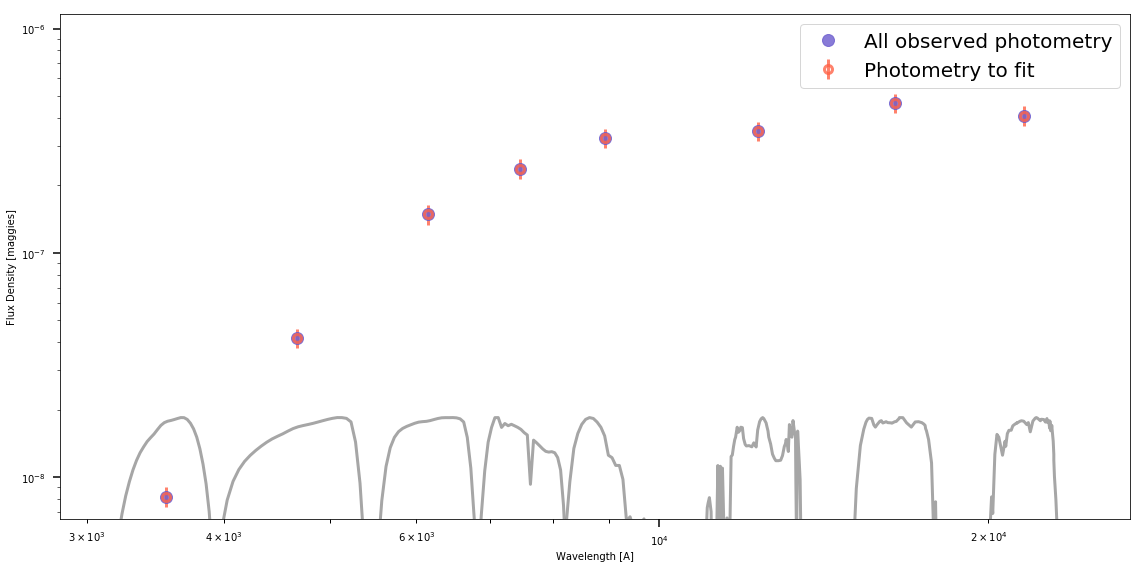

In [5]:
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])
#print(obs['phot_mask'])
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
print(obs['filters'][-2].transmission)
print(obs['filters'][-2].wavelength)
# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

In [6]:
from prospect.models import priors
from prospect.models.templates import TemplateLibrary

In [20]:
def build_model(object_redshift=None, fixed_metallicity=None, add_nebular=False, 
                **extras):

    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors


    model_params = TemplateLibrary["parametric_sfh"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.

    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.05
    model_params["logzsol"]["init"] = 0.01
    model_params["tage"]["init"] = 9.
    model_params["mass"]["init"] = 9e11
    
    # These are dwarf galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=50)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e9, maxi=1e12)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e5
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_nebular:
        model_params.update(TemplateLibrary["nebular"])
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model


run_params["object_redshift"] = 0.225
run_params["fixed_metallicity"] = None
run_params["add_nebular"] = True

In [21]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(maxi=1000000000000.0,mini=1000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(maxi=2.0,mini=0.0)
  tage: <class 'prospect.models.priors.TopHat'>(maxi=13.8,mini=0.001)
  tau: <class 'prospect.models.priors.LogUniform'>(maxi=50,mini=0.1)
  logzsol: <class 'prospect.models.priors.TopHat'>(maxi=0.19,mini=-2)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  add_neb_continuum: True 
  add_neb_emission: True 
  zred: 0.225 
  dust_type: 0 
  gas_logu: -2.0 
  imf_type: 2 
  sfh: 4 
  nebemlineinspec: True 
  gas_logz: 0.0 <function stellar_logzsol at 0x7f8ca7ba50d0>

Initial free parameter vector theta:
  [9.e+11 5.e-02 9.e+00 1.e+00 1.e-02]

Initial parameter dictionary:
{'mass': array([9.e+11]), 'dust2': array([0.05]), 'tage': array([9.]), 'add_neb_continuum': array([ True]), 'add_neb_emission': array([ True]), 'zred': 

In [22]:
def build_sps(zcontinuous=1, **extras):
    
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [23]:
sps = build_sps(**run_params)

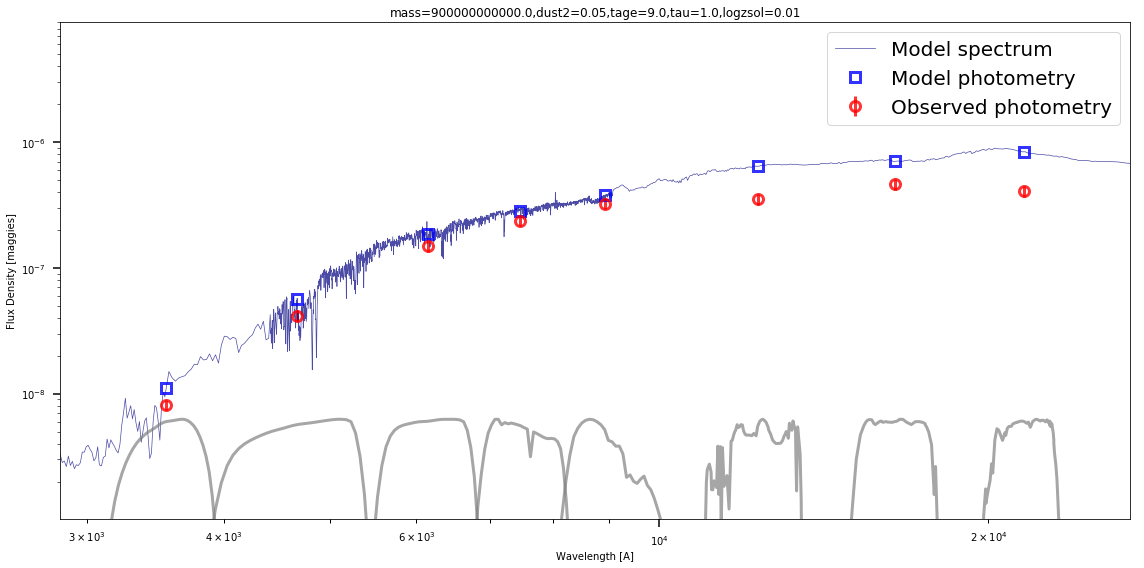

In [24]:
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.225) 
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a 
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.4, temp.max()/0.1
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


In [25]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=True, verbose=verbose):

    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
    # Calculate likelihoods
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

In [26]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):

    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.infty

    # Generate mean model
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.infty

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

In [27]:
from prospect.fitting import lnprobfn
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

print(sps.ssp.libraries)

from prospect.fitting import fit_model

(b'mist', b'miles')


In [28]:
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 2

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log


Done optmization in 398.64873027801514s


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


[ 9.99999986e+11  1.37536739e+00  1.15654871e+01  1.20625920e+00
 -1.73123384e+00]
0
[ 9.99999986e+11  1.37536739e+00  1.15654871e+01  1.20625920e+00
 -1.73123384e+00]


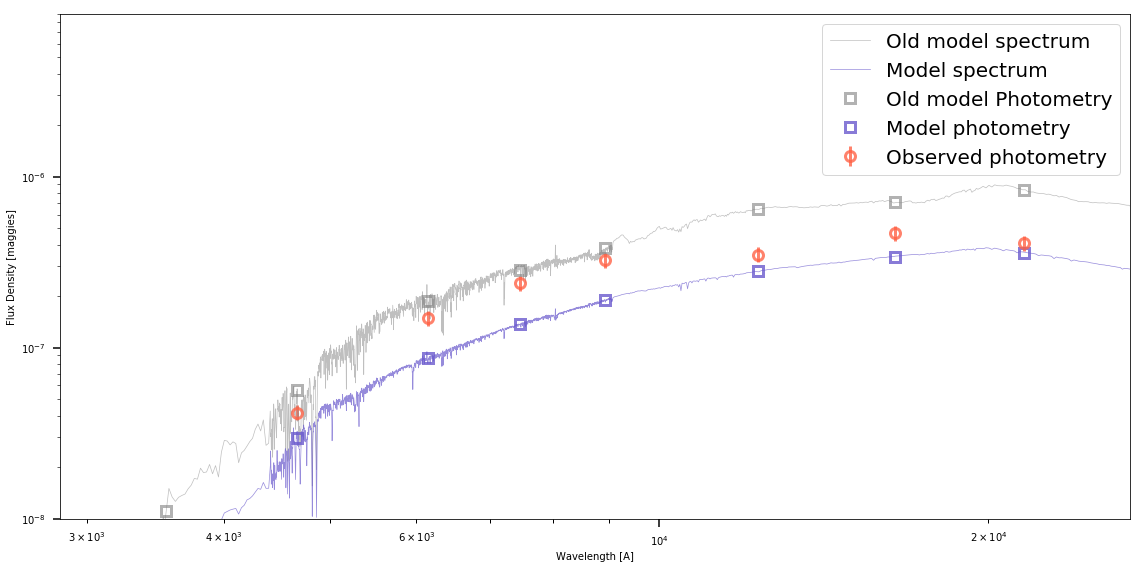

In [29]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([1e-8, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [30]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nested_bound"] = 'multi'
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [31]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
iter: 4233 | batch: 8 | nc: 1 | ncall: 15049 | eff(%): 26.244 | loglstar: 127.213 < 132.650 < 131.497 | logz: 123.485 +/-  0.269 | stop:  1.197     

done dynesty in 881.4832649230957s


In [32]:
from prospect.io import write_results as writer
hfile = "050509b_dynesty.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:254: UserWarning: Could not JSON serialize ndof, pickled instead


In [33]:
import prospect.io.read_results as reader
results_type = "dynesty"
result, obs, _ = reader.results_from("050509b_dynesty.h5".format(results_type), dangerous=False)
print(result.keys())

dict_keys(['information', 'logz', 'model', 'run_params', 'obs', 'niter', 'lnprobability', 'logvol', 'weights', 'paramfile_text', 'theta_labels', 'logzerr', 'optimization_results', 'lnlikelihood', 'model_params', 'samples_id', 'sampling_duration', 'prospector_version', 'ncall', 'efficiency', 'optimizer_duration', 'chain'])


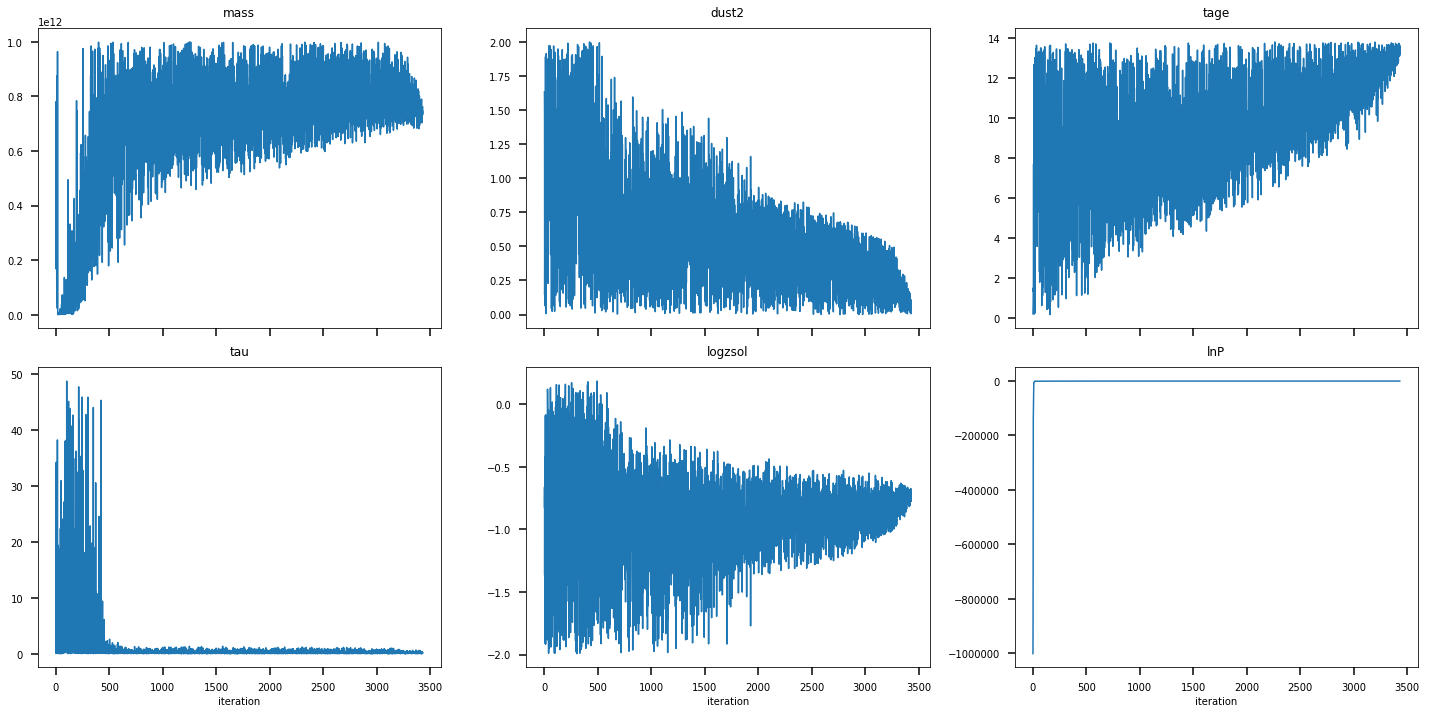

In [34]:
tracefig = reader.traceplot(result, figsize=(20,10))

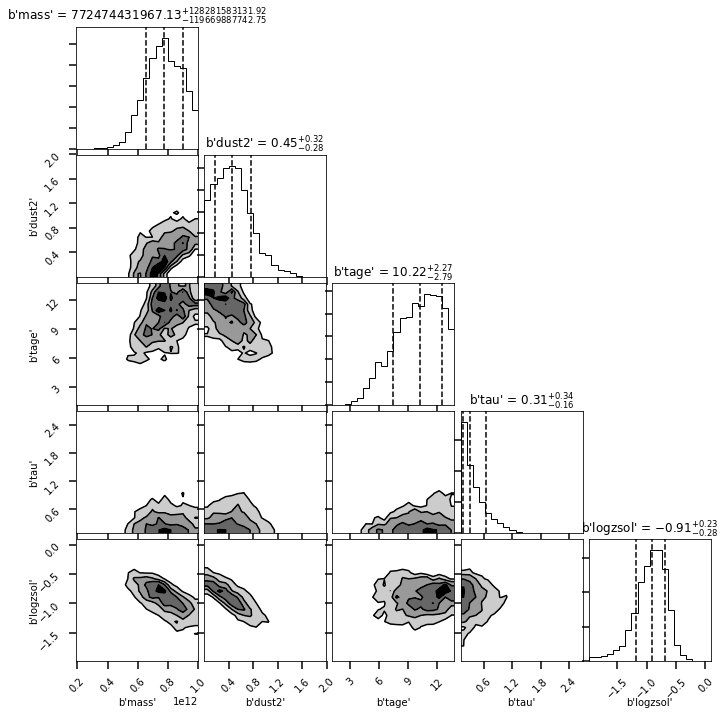

In [43]:
result, obs, model = reader.results_from("050509b_dynesty.h5")
imax = np.argmax(result['lnprobability'])

# The theta_max values give the most probable vales
theta_max = result['chain'][imax, :].copy()

# We start our corner plots 500 iterations in, as the iterations before this usually have nonsensical/ low 
# probability values
cornerfig = reader.subcorner(result, start=500, thin=1,
                      fig=subplots(5,5,figsize=(10,10))[0], fontsize=100)

In [63]:
sps = build_sps(**run_params)
model = build_model(**run_params)

flatchain = result['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
             for i in range(model.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)




[772466620596.7723, 0.4479145324088343, 10.217125660695965, 0.3070151685689632, -0.9076821400874894]
[3.70451325e-07 4.27024790e-07 4.51944816e-07 8.26907250e-09
 4.31821868e-08 1.30597805e-07 1.99263584e-07 2.62450386e-07]


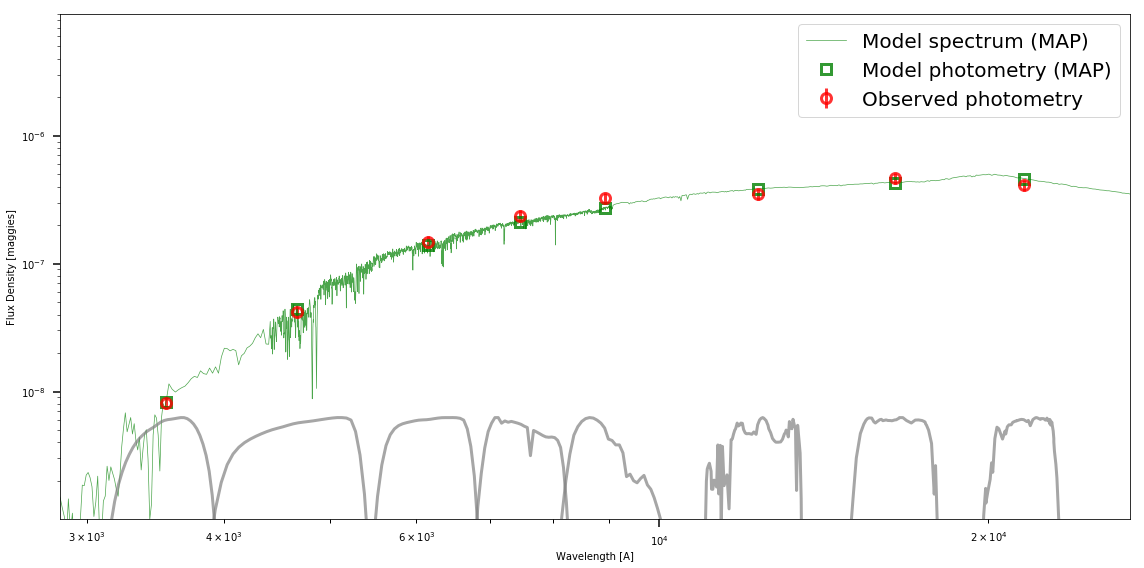

In [64]:
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)

errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()
